In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from bisect import bisect_left
import statsmodels.api as sm
import glob

From the paper:

"Because we are using relative fitness, the effect of each individual drug can be interpreted as a percent reduction in growth rate, so the null expectation for the combined effects of two non-interacting drugs would be the product of two percentages, corresponding to a multiplicative definition of no interaction."

so cases compared to control in terms of fold differences, multiplciative model.

In [2]:
Lozano_2021_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/drug_data/Lozano-HuntelmanEtAl2021/Raw Data and Growth Rate/Interaction Calculation/Data/Data/output_29-Oct-2020_log data/publish data_log"
Lozano_2021 = pd.read_csv(f"{Lozano_2021_data_dir}/FOX.FUS.STR.DOX.TMP.csv_PublishData.csv", sep=",")
Lozano_2021 = Lozano_2021.loc[:, "combinations":"X1X2X3X4X5"]

files = glob.glob(Lozano_2021_data_dir + "/*.csv")
df = pd.DataFrame
for f in files:
    tmp = pd.read_csv(f, sep=",")
    tmp = tmp.loc[:, "combinations":"X1X2X3X4X5"]
    tmp = tmp.tail(n=1)
    try:
        df = pd.concat([df, tmp], axis=0)
    except:
        df = tmp
df.loc[:, "combinations"] = df.combinations.str.replace("3","_")
df = df.reset_index(drop=True)



In [3]:
df_sing = df.loc[:,"X1":"X5"].reset_index(drop=True)
df_doub = df.loc[:,"X1X2":"X4X5"].reset_index(drop=True)
df_trip = df.loc[:,"X1X2X3":"X3X4X5"].reset_index(drop=True)
df_quad = df.loc[:,"X1X2X3X4":"X2X3X4X5"].reset_index(drop=True)
df_quin = df.loc[:,"X1X2X3X4X5"].reset_index(drop=True)

In [4]:
# one of the columns has an extra whitespace
df_trip = df_trip.rename(columns={'X1X4X5 ' : 'X1X4X5'})

[Text(0.5, 0, 'fitness'), Text(0, 0.5, '')]

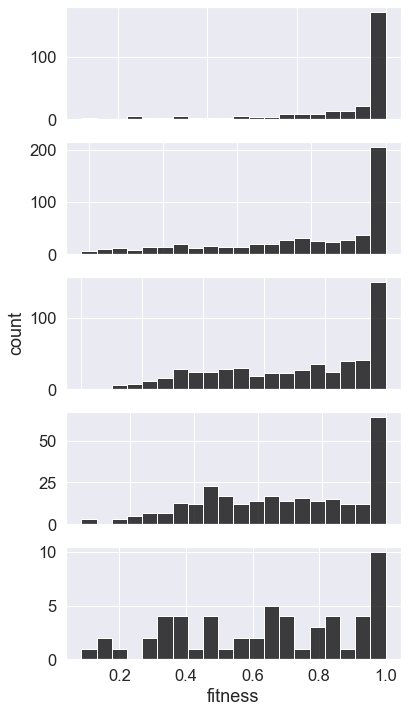

In [5]:
sns.set(font_scale = 1.5)
fig, axs = plt.subplots(nrows=5, figsize=(15,5))
fig.set_size_inches(6, 12)
bins=20

def mk_plot_data(df):
    x = []
    [x.extend(list(df[i])) for i in list(df.columns)]
    return x

p = sns.histplot(mk_plot_data(df_sing),  color="black", bins = bins, ax=axs[0])
axs[0].set(xlabel=None, ylabel=None, xticklabels=[])
p = sns.histplot(mk_plot_data(df_doub),  color="black", bins = bins, ax=axs[1])
axs[1].set(xlabel=None, ylabel=None, xticklabels=[])
p = sns.histplot(mk_plot_data(df_trip),  color="black", bins = bins, ax=axs[2])
axs[2].set(xlabel=None, ylabel="count", xticklabels=[])
p = sns.histplot(mk_plot_data(df_quad),  color="black", bins = bins, ax=axs[3])
axs[3].set(xlabel=None, ylabel=None, xticklabels=[])
p = sns.histplot(df_quin,  color="black", bins = bins, ax=axs[4])
axs[4].set(xlabel="fitness", ylabel=None)


In [6]:
print(len(df_sing))
print(len(df_doub))
print(len(df_trip))
print(len(df_quad))
print(len(df_quin))



56
56
56
56
56


In [7]:
def get_fitness_triple_interaction(df_sing, df_doub, df_trip, col):
    f = [col[i:i+2] for i in range(0, len(col), 2)]
    f_ijk = df_trip[col]
    f_i = df_sing[f[0]]
    f_j = df_sing[f[1]]
    f_k = df_sing[f[2]]
    f_ij = df_doub[f[0]+f[1]]
    f_ik = df_doub[f[0]+f[2]]
    f_jk = df_doub[f[1]+f[2]]
    return f_ijk, f_i, f_j, f_k, f_ij, f_ik, f_jk

def get_fitness_quadruple_interaction(df_sing, df_doub, df_trip, df_quad, col):
    fitnesses = defaultdict(pd.Series)

    f = [col[i:i+2] for i in range(0, len(col), 2)]

    fitnesses[1234] = df_quad[col]

    fitnesses[123] = df_trip[f[0]+f[1]+f[2]]
    fitnesses[124] = df_trip[f[0]+f[1]+f[3]]
    fitnesses[134] = df_trip[f[0]+f[2]+f[3]]
    fitnesses[234] = df_trip[f[1]+f[2]+f[3]]

    fitnesses[12] = df_doub[f[0]+f[1]]
    fitnesses[13] = df_doub[f[0]+f[2]]
    fitnesses[14] = df_doub[f[0]+f[3]]
    fitnesses[23] = df_doub[f[1]+f[2]]
    fitnesses[24] = df_doub[f[1]+f[3]]
    fitnesses[34] = df_doub[f[2]+f[3]]

    fitnesses[1] = df_sing[f[0]]
    fitnesses[2] = df_sing[f[1]]
    fitnesses[3] = df_sing[f[2]]
    fitnesses[4] = df_sing[f[3]]
    
    return fitnesses

for col in df_doub.columns:
    f = [col[i:i+2] for i in range(0, len(col), 2)]
    #print(f_i)
    name = col + "_iss"
    df_doub.loc[:, name] = df_doub[col] - (df_sing[f[0]]*df_sing[f[1]])
    name = col + "_mult"
    df_doub.loc[:, name] = df_doub[col]/(df_sing[f[0]]*df_sing[f[1]])

for col in df_trip.columns:
    f_ijk, f_i, f_j, f_k, f_ij, f_ik, f_jk = get_fitness_triple_interaction(df_sing, df_doub, df_trip, col)
    name = col + "_iss"
    df_trip.loc[:, name] = f_ijk + 2*f_i*f_j*f_k - f_ij*f_k - f_ik*f_j - f_jk*f_i
    name = col + "_mult"
    df_trip.loc[:, name] = (f_ijk*f_i*f_j*f_k)/(f_ij*f_ik*f_jk)

for col in df_quad.columns:
    f = get_fitness_quadruple_interaction(df_sing, df_doub, df_trip, df_quad, col)
    name = col + "_iss"
    df_quad.loc[:, name] = f[1234] - f[1]*f[234] - f[2]*f[134] - f[3]*f[124] - f[4]*f[123] - f[12]*f[34] - f[13]*f[24] - f[14]*f[23] + (2*f[1]*f[2]*f[34]) + (2*f[1]*f[3]*f[24]) + (2*f[1]*f[4]*f[23]) + (2*f[2]*f[3]*f[14]) + (2*f[2]*f[4]*f[13]) + (2*f[3]*f[4]*f[12]) - (6*f[1]*f[2]*f[3]*f[4])
    name = col + "_mult"
    df_quad.loc[:, name] = (f[1234]*f[12]*f[13]*f[14]*f[23]*f[24]*f[34])/(f[1]*f[2]*f[3]*f[4]*f[123]*f[124]*f[134]*f[234])

[Text(0.5, 0, 'iss'), Text(0, 0.5, 'mult')]

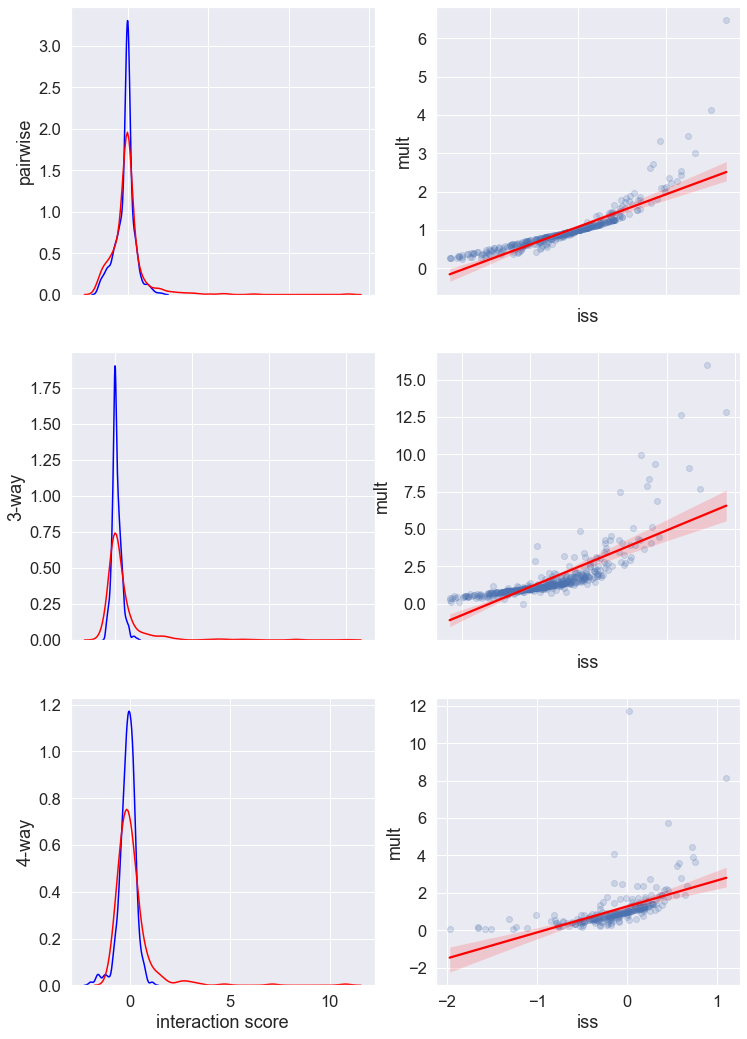

In [63]:
sns.set(font_scale = 1.5)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,5))
fig.set_size_inches(12, 18)
bins=20
bw=0.8
def mk_plot_data(df):
    x = []
    [x.extend(list(df[i])) for i in list(df.columns)]
    return x

##################
sns.kdeplot(mk_plot_data(df_doub.filter(regex=(".*_iss"))),  color="blue", bw_adjust=bw, ax=axs[0,0])
sns.kdeplot(mk_plot_data(df_doub.filter(regex=(".*_mult"))-1),  color="red", bw_adjust=bw, ax=axs[0,0])
axs[0,0].set(xlabel=None, ylabel="pairwise", xticklabels=[])

sns.regplot(x=mk_plot_data(df_doub.filter(regex=(".*_iss"))),  
            y=mk_plot_data(df_doub.filter(regex=(".*_mult"))),  
            scatter_kws={'alpha':0.2},
            line_kws={'color': 'red'},
            ax=axs[0,1])
axs[0,1].set(xlabel="iss", ylabel="mult", xticklabels=[])

##################
sns.kdeplot(mk_plot_data(df_trip.filter(regex=(".*_iss"))),  color="blue", bw_adjust=bw, ax=axs[1,0])
sns.kdeplot(mk_plot_data(df_trip.filter(regex=(".*_mult"))-1),  color="red", bw_adjust=bw, ax=axs[1,0])
axs[1,0].set(xlabel=None, ylabel="3-way", xticklabels=[])

sns.regplot(x=mk_plot_data(df_trip.filter(regex=(".*_iss"))), 
            y=mk_plot_data(df_trip.filter(regex=(".*_mult"))),  
            scatter_kws={'alpha':0.2},
            line_kws={'color': 'red'},
            ax=axs[1,1])
axs[1,1].set(xlabel="iss", ylabel="mult", xticklabels=[])

##################
sns.kdeplot(mk_plot_data(df_quad.filter(regex=(".*_iss"))),  color="blue", bw_adjust=bw, ax=axs[2,0])
sns.kdeplot(mk_plot_data(df_quad.filter(regex=(".*_mult"))-1),  color="red", bw_adjust=bw, ax=axs[2,0])
axs[2,0].set(xlabel="interaction score", ylabel="4-way")

y = np.array(mk_plot_data(df_quad.filter(regex=(".*_mult"))))
x = np.array(mk_plot_data(df_quad.filter(regex=(".*_iss"))))
x[np.isfinite(y)]
y[np.isfinite(y)]
sns.regplot(x=x[np.isfinite(y)],
            y=y[np.isfinite(y)],  
            scatter_kws={'alpha':0.2},
            line_kws={'color': 'red'},
            ax=axs[2,1])
axs[2,1].set(xlabel="iss", ylabel="mult")


NOTE: for correlation analyses, there are some duplicate measurements in these data... although they don't have the exact same values across experiments

In [34]:
d = { "iss" : mk_plot_data(df_doub.filter(regex=(".*_iss"))),
        "mult" : mk_plot_data(df_doub.filter(regex=(".*_mult"))) }
tmp = pd.DataFrame.from_dict(d)
print(tmp.corr(method="pearson"))
print(tmp.corr(method="spearman"))



           iss      mult
iss   1.000000  0.848952
mult  0.848952  1.000000
           iss      mult
iss   1.000000  0.996507
mult  0.996507  1.000000


In [35]:
d = { "iss" : mk_plot_data(df_trip.filter(regex=(".*_iss"))),
        "mult" : mk_plot_data(df_trip.filter(regex=(".*_mult"))) }
tmp = pd.DataFrame.from_dict(d)
print(tmp.corr(method="pearson"))
print(tmp.corr(method="spearman"))

           iss      mult
iss   1.000000  0.771388
mult  0.771388  1.000000
           iss      mult
iss   1.000000  0.951421
mult  0.951421  1.000000


In [36]:
d = { "iss" : mk_plot_data(df_quad.filter(regex=(".*_iss"))),
        "mult" : mk_plot_data(df_quad.filter(regex=(".*_mult"))) }
tmp = pd.DataFrame.from_dict(d)
print(tmp.corr(method="pearson"))
print(tmp.corr(method="spearman"))

           iss      mult
iss   1.000000  0.541152
mult  0.541152  1.000000
           iss      mult
iss   1.000000  0.868375
mult  0.868375  1.000000


In [27]:
print(np.std(mk_plot_data(df_doub.filter(regex=(".*_iss")))))
print(np.std(mk_plot_data(df_doub.filter(regex=(".*_mult")))))

print(np.std(mk_plot_data(df_trip.filter(regex=(".*_iss")))))
print(np.std(mk_plot_data(df_trip.filter(regex=(".*_mult")))))

print(np.std(mk_plot_data(df_quad.filter(regex=(".*_iss")))))

x = np.array(mk_plot_data(df_quad.filter(regex=(".*_mult"))))
print(np.std(x[np.isfinite(x)]))

0.23308232562095335
0.46478239478415256
0.2980648875290462
1.4644471703215083
0.407684622875828
1.0471200131039813


In [28]:
print(np.mean(mk_plot_data(df_doub.filter(regex=(".*_iss")))))
print(np.mean(mk_plot_data(df_doub.filter(regex=(".*_mult")))))

print(np.mean(mk_plot_data(df_trip.filter(regex=(".*_iss")))))
print(np.mean(mk_plot_data(df_trip.filter(regex=(".*_mult")))))

print(np.mean(mk_plot_data(df_quad.filter(regex=(".*_iss")))))

x = np.array(mk_plot_data(df_quad.filter(regex=(".*_mult"))))
print(np.mean(x[np.isfinite(x)]))

-0.05558330466839286
0.986527714516328
0.09405429333805583
1.4681417390585534
-0.13282290918735912
1.0908688323382079


In [29]:
print(np.median(mk_plot_data(df_doub.filter(regex=(".*_iss")))))
print(np.median(mk_plot_data(df_doub.filter(regex=(".*_mult")))))

print(np.median(mk_plot_data(df_trip.filter(regex=(".*_iss")))))
print(np.median(mk_plot_data(df_trip.filter(regex=(".*_mult")))))

print(np.median(mk_plot_data(df_quad.filter(regex=(".*_iss")))))

x = np.array(mk_plot_data(df_quad.filter(regex=(".*_mult"))))
print(np.median(x[np.isfinite(x)]))

0.0
1.0
0.03404500000000005
1.0403603611301528
-0.09088929205046703
0.9043338336078572
